# Table of Contents
 <p><div class="lev1 toc-item"><a href="#comparison-of-ellipticity-for-lower-and-upper-median-flux" data-toc-modified-id="comparison-of-ellipticity-for-lower-and-upper-median-flux-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>comparison of ellipticity for lower and upper median flux</a></div><div class="lev1 toc-item"><a href="#imcat-commands-used" data-toc-modified-id="imcat-commands-used-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>imcat commands used</a></div><div class="lev1 toc-item"><a href="#Looking-ellipticity" data-toc-modified-id="Looking-ellipticity-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Looking ellipticity</a></div><div class="lev1 toc-item"><a href="#Looking-final-text" data-toc-modified-id="Looking-final-text-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Looking final text</a></div><div class="lev1 toc-item"><a href="#Compare-lower-median-and-upper-median-flux-for-ellipticity" data-toc-modified-id="Compare-lower-median-and-upper-median-flux-for-ellipticity-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Compare lower median and upper median flux for ellipticity</a></div>

# comparison of ellipticity for lower and upper median flux
Date: Jun 18, 2019
filetype: z=1.5 and ngals=10k for 100 files

filtering: 
- flag calib psf candidate == false
- parameter deblend nchile == 0
- maths: e = sqrt(e1**2 + e2**2) <= 1.5
- removed nans


Output:
```
df_low['gm_sq'].mean() / df_high['gm_sq'].mean() = 1.22
df_low['gc_sq'].mean() / df_high['gc_sq'].mean() = 1.21
```

# imcat commands used
```bash
# First we get dmstack output in l.csv which have 90 flags + 76 parameters.
# Then, we choose only 8 parameters, remove nans, and change 
# delimiter from comma to tab.
#
# python remove_nans_dmstack.py l.csv gives l.txt with 8 columns.
#
# column 0: id = id
# column 1,2: x = base_SdssCentroid_x, base_SdssCentroid_y
# column 3,4: errx = base_SdssCentroid_xSigma, base_SdssCentroid_ySigma
# column 5,6: e = ext_shapeHSM_HsmShapeRegauss_e1, ext_shapeHSM_HsmShapeRegauss_e2
# column 8: flux = base_SdssShape_flux  (there are other flux e.g. 
#                  base_CicularApertureFlux_3_0_flux, 4.5,6.0,9.0,12.0 etc
#                  base_GaussianFlux_flux
# I checked sdss vs gaussian scatterplot, they look linearly dependent, so
# we can use either of them, but I am using sdss.

# In Total there are 8 columns.
#
# Note: here g is g/2 since e=sqrt(e1**2+e2**2) and in Weak lensing limit
# <e_i>/2 ~ g_i   where index i is t or c i.e. tangential or cross components.
#############
# Required: This program needs four text files e.g. l.txt,l9.txt,m.txt and m9.txt
#
# Outputs: final.cat (also temporary outputs e.g. l,l9,m,m9.cat and merge.cat)

z=1.5
BEGIN=0
END=99 # end is included

# main output folder
mkdir -p final

# loop through range of files
for i in $(seq -f "%03g" $BEGIN $END)
do
L="src_lsst_z${z}_${i}"
L9="src_lsst90_z${z}_${i}"
M="src_lsst_mono_z${z}_${i}"
M9="src_lsst_mono90_z${z}_${i}"

# create lc catalog from text file
# the first column id and last column ellipticiy are not used.
#echo "Creating: .cat files";
lc -C -n id -N '1 2 x' -N '1 2 errx' -N '1 2 g' -n flux < "${L}".txt > "${L}".cat
lc -C -n id -N '1 2 x' -N '1 2 errx' -N '1 2 g' -n flux < "${L9}".txt > "${L9}".cat

lc -C -n id -N '1 2 x' -N '1 2 errx' -N '1 2 g' -n flux < "${M}".txt > "${M}".cat
lc -C -n id -N '1 2 x' -N '1 2 errx' -N '1 2 g' -n flux < "${M9}".txt > "${M9}".cat

# merge the 4 catalogs to a single catalog
# Make sure mergecats have mono files first and then chromatic files later
# to comply with the command to create final.cat.
#echo "Creating: merge.cat"
mergecats 5 "${M}".cat "${M9}".cat "${L}".cat "${L9}".cat > merge.cat &&
#echo "Created: merge.cat"

# convert the merge catalog into a catalog with mono and color shear values with the 0 degree and 90 degree values averaged:
#echo "Creating: final.cat";
lc -b +all 'x = %x[0][0] %x[1][0] + %x[2][0] + %x[3][0] + 4 / %x[0][1] %x[1][1] + %x[2][1] + %x[3][1] + 4 / 2 vector' 'gm = %g[0][0] %g[1][0] + 2 / %g[0][1] %g[1][1] + 2 / 2 vector' 'gc = %g[2][0] %g[3][0] + 2 / %g[2][1] %g[3][1] + 2 / 2 vector' < merge.cat > final/final_${i}.cat

echo "Created: final/final_${i}.cat"
done;

# combine all cats
cd final;
catcats *.cat > final.cat

# convert binary to text
lc -O < final.cat > final_text.cat 
```

In [26]:
# !cat ../my_imcat_commands.sh

# Looking ellipticity

In [15]:
!head -2 ../src_lsst_z1.5_000.txt

# id           base_SdssCentroid_x           base_SdssCentroid_y           base_SdssCentroid_xSigma           base_SdssCentroid_ySigma           ext_shapeHSM_HsmShapeRegauss_e1           ext_shapeHSM_HsmShapeRegauss_e2           base_SdssShape_flux
3.000000000000000000e+01	1.877364299999999957e+03	2.783330000000000126e+01	3.300000000000000155e-01	2.990999999999999770e-01	1.607999999999999985e-01	-2.922000000000000153e-01	3.044910100000000057e+03


In [ ]:
infile = '../src_lsst_z1.5_000.txt'
df = pd.read_csv(infile,header=None,sep=r'\s+',comment='#')
df.head()

In [22]:
%matplotlib inline

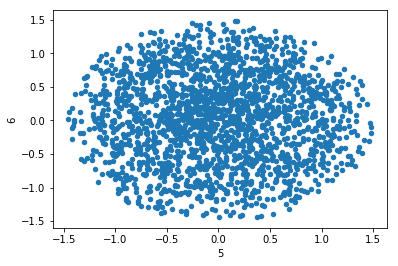

In [23]:
df.plot.scatter(x=5,y=6)

# Looking final text

In [12]:
!head -2 final_text.txt

#       id[0][0]       id[1][0]       id[2][0]       id[3][0]           x[0]           x[1]     errx[0][0]     errx[0][1]     errx[1][0]     errx[1][1]     errx[2][0]     errx[2][1]     errx[3][0]     errx[3][1]        g[0][0]        g[0][1]        g[1][0]        g[1][1]        g[2][0]        g[2][1]        g[3][0]        g[3][1]     flux[0][0]     flux[1][0]     flux[2][0]     flux[3][0]          gm[0]          gm[1]          gc[0]          gc[1]
            5678           5735           5568           5678      1969.2159      2159.7569         0.1046         0.0759         0.1063         0.0745         0.1055         0.0759          0.107         0.0746          1.083        -0.2341         1.1499        -0.4244         1.1705        -0.2617         1.2105        -0.4458      8119.9753      8214.5911      8109.6423      8206.3494        1.11645       -0.32925         1.1905       -0.35375


# Compare lower median and upper median flux for ellipticity

In [2]:
import numpy as np
import pandas as pd

infile = 'final_text.txt'
headers = pd.read_csv(infile,sep=r'\s+',nrows=1).columns

headers = headers[1:] # remove first # column
headers

Index(['id[0][0]', 'id[1][0]', 'id[2][0]', 'id[3][0]', 'x[0]', 'x[1]',
       'errx[0][0]', 'errx[0][1]', 'errx[1][0]', 'errx[1][1]', 'errx[2][0]',
       'errx[2][1]', 'errx[3][0]', 'errx[3][1]', 'g[0][0]', 'g[0][1]',
       'g[1][0]', 'g[1][1]', 'g[2][0]', 'g[2][1]', 'g[3][0]', 'g[3][1]',
       'flux[0][0]', 'flux[1][0]', 'flux[2][0]', 'flux[3][0]', 'gm[0]',
       'gm[1]', 'gc[0]', 'gc[1]'],
      dtype='object')

In [3]:
df = pd.read_csv(infile,sep=r'\s+',comment='#',header=None)
df.columns = headers
df.head()

,id[0][0],id[1][0],id[2][0],id[3][0],x[0],x[1],errx[0][0],errx[0][1],errx[1][0],errx[1][1],...,g[3][0],g[3][1],flux[0][0],flux[1][0],flux[2][0],flux[3][0],gm[0],gm[1],gc[0],gc[1]
0,5678,5735,5568,5678,1969.21590,2159.75690,0.1046,0.0759,0.1063,0.0745,...,1.2105,-0.4458,8119.9753,8214.5911,8109.6423,8206.3494,1.11645,-0.32925,1.19050,-0.35375
1,3181,3193,3164,3179,2222.70820,480.46175,0.0084,0.0080,0.0078,0.0086,...,-0.2665,-0.5215,53940.3420,53844.2740,53930.3800,53825.1630,0.09625,0.05815,0.08565,0.06530
2,617,629,634,631,2490.22380,808.50175,0.1954,0.2183,0.1988,0.2101,...,-0.0540,-0.5692,1992.9584,2009.3786,1981.6793,2005.1267,-0.30090,-0.46295,-0.34460,-0.37255
3,684,696,699,698,3373.27020,905.54893,0.0547,0.0594,0.0549,0.0592,...,0.3317,-0.3053,6554.3191,6547.4142,6556.4337,6549.9094,-0.15520,-0.07390,-0.17915,-0.16215
4,7439,7449,7225,7379,469.49428,3091.40550,0.1649,0.1191,0.1122,0.1652,...,-0.8725,0.6541,5283.5760,5059.5502,5279.9345,5064.7001,0.01340,0.03275,0.00085,0.03555


In [4]:
df.iloc[0]

id[0][0]      5678.00000
id[1][0]      5735.00000
id[2][0]      5568.00000
id[3][0]      5678.00000
x[0]          1969.21590
x[1]          2159.75690
errx[0][0]       0.10460
errx[0][1]       0.07590
errx[1][0]       0.10630
errx[1][1]       0.07450
errx[2][0]       0.10550
errx[2][1]       0.07590
errx[3][0]       0.10700
errx[3][1]       0.07460
g[0][0]          1.08300
g[0][1]         -0.23410
g[1][0]          1.14990
g[1][1]         -0.42440
g[2][0]          1.17050
g[2][1]         -0.26170
g[3][0]          1.21050
g[3][1]         -0.44580
flux[0][0]    8119.97530
flux[1][0]    8214.59110
flux[2][0]    8109.64230
flux[3][0]    8206.34940
gm[0]            1.11645
gm[1]           -0.32925
gc[0]            1.19050
gc[1]           -0.35375
Name: 0, dtype: float64

In [5]:
df['flux'] = df['flux[0][0]'] + df['flux[1][0]'] + df['flux[2][0]'] + df['flux[3][0]']
df['gm_sq'] = df['gm[0]']**2 + df['gm[1]']**2
df['gc_sq'] = df['gc[0]']**2 + df['gc[1]']**2
df.head()

,id[0][0],id[1][0],id[2][0],id[3][0],x[0],x[1],errx[0][0],errx[0][1],errx[1][0],errx[1][1],...,flux[1][0],flux[2][0],flux[3][0],gm[0],gm[1],gc[0],gc[1],flux,gm_sq,gc_sq
0,5678,5735,5568,5678,1969.21590,2159.75690,0.1046,0.0759,0.1063,0.0745,...,8214.5911,8109.6423,8206.3494,1.11645,-0.32925,1.19050,-0.35375,32650.5581,1.354866,1.542429
1,3181,3193,3164,3179,2222.70820,480.46175,0.0084,0.0080,0.0078,0.0086,...,53844.2740,53930.3800,53825.1630,0.09625,0.05815,0.08565,0.06530,215540.1590,0.012645,0.011600
2,617,629,634,631,2490.22380,808.50175,0.1954,0.2183,0.1988,0.2101,...,2009.3786,1981.6793,2005.1267,-0.30090,-0.46295,-0.34460,-0.37255,7989.1430,0.304864,0.257543
3,684,696,699,698,3373.27020,905.54893,0.0547,0.0594,0.0549,0.0592,...,6547.4142,6556.4337,6549.9094,-0.15520,-0.07390,-0.17915,-0.16215,26208.0764,0.029548,0.058387
4,7439,7449,7225,7379,469.49428,3091.40550,0.1649,0.1191,0.1122,0.1652,...,5059.5502,5279.9345,5064.7001,0.01340,0.03275,0.00085,0.03555,20687.7608,0.001252,0.001265


In [6]:
med = df['flux'].median()
med

37208.710900000005

In [7]:
df['flux_median_low'] = df['flux'] <= med
df.head()

,id[0][0],id[1][0],id[2][0],id[3][0],x[0],x[1],errx[0][0],errx[0][1],errx[1][0],errx[1][1],...,flux[2][0],flux[3][0],gm[0],gm[1],gc[0],gc[1],flux,gm_sq,gc_sq,flux_median_low
0,5678,5735,5568,5678,1969.21590,2159.75690,0.1046,0.0759,0.1063,0.0745,...,8109.6423,8206.3494,1.11645,-0.32925,1.19050,-0.35375,32650.5581,1.354866,1.542429,True
1,3181,3193,3164,3179,2222.70820,480.46175,0.0084,0.0080,0.0078,0.0086,...,53930.3800,53825.1630,0.09625,0.05815,0.08565,0.06530,215540.1590,0.012645,0.011600,False
2,617,629,634,631,2490.22380,808.50175,0.1954,0.2183,0.1988,0.2101,...,1981.6793,2005.1267,-0.30090,-0.46295,-0.34460,-0.37255,7989.1430,0.304864,0.257543,True
3,684,696,699,698,3373.27020,905.54893,0.0547,0.0594,0.0549,0.0592,...,6556.4337,6549.9094,-0.15520,-0.07390,-0.17915,-0.16215,26208.0764,0.029548,0.058387,True
4,7439,7449,7225,7379,469.49428,3091.40550,0.1649,0.1191,0.1122,0.1652,...,5279.9345,5064.7001,0.01340,0.03275,0.00085,0.03555,20687.7608,0.001252,0.001265,True


In [8]:
df_low = df[df['flux_median_low']==True]
df_high = df[df['flux_median_low']==False]

df_low.head()

,id[0][0],id[1][0],id[2][0],id[3][0],x[0],x[1],errx[0][0],errx[0][1],errx[1][0],errx[1][1],...,flux[2][0],flux[3][0],gm[0],gm[1],gc[0],gc[1],flux,gm_sq,gc_sq,flux_median_low
0,5678,5735,5568,5678,1969.21590,2159.75690,0.1046,0.0759,0.1063,0.0745,...,8109.6423,8206.3494,1.11645,-0.32925,1.19050,-0.35375,32650.5581,1.354866,1.542429,True
2,617,629,634,631,2490.22380,808.50175,0.1954,0.2183,0.1988,0.2101,...,1981.6793,2005.1267,-0.30090,-0.46295,-0.34460,-0.37255,7989.1430,0.304864,0.257543,True
3,684,696,699,698,3373.27020,905.54893,0.0547,0.0594,0.0549,0.0592,...,6556.4337,6549.9094,-0.15520,-0.07390,-0.17915,-0.16215,26208.0764,0.029548,0.058387,True
4,7439,7449,7225,7379,469.49428,3091.40550,0.1649,0.1191,0.1122,0.1652,...,5279.9345,5064.7001,0.01340,0.03275,0.00085,0.03555,20687.7608,0.001252,0.001265,True
9,896,906,913,907,2314.63130,1202.06340,0.1476,0.1504,0.1406,0.1562,...,2672.9453,2702.5893,0.09005,0.34230,0.06745,0.29990,10735.6398,0.125278,0.094490,True


In [9]:
df_low['gm_sq'].mean() / df_high['gm_sq'].mean()

1.2226981913436057

In [10]:
df_low['gc_sq'].mean() / df_high['gc_sq'].mean()

1.2116514632391944